In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import random 
import numpy.random as rand
from random import randrange
from scipy.stats import bernoulli, binom
from sklearn.linear_model import LinearRegression
import seaborn as sns
import scipy
from scipy import stats 
import researchpy as rp
import cdt


No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


# 1.  Load data sets 

In [2]:
#load experimental data 
nsw = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Data/nsw.dta")
del nsw['data_id']
#load non experimental data (cps)
cps1 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Data/cps_controls.dta")
cps2 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Data/cps_controls2.dta")
cps3 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Data/cps_controls3.dta")
#load non experimental data (psid)
psid1 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Data/psid_controls.dta")
psid2 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Data/psid_controls2.dta")
psid3 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Data/psid_controls3.dta")



In [3]:
# Clean up data 

#Convert to numberic 
for i in nsw.columns:
  pd.to_numeric(nsw[i])

# Take natural log of outcome 
nsw['re78'].replace(to_replace = 0, value = 1 , inplace=True)
nsw['re78']  = np.log(nsw['re78'])

# Take natural log of wages 1975 
nsw['re75'].replace(to_replace = 0, value = 1 , inplace=True)
nsw['re75']  = np.log(nsw['re75'])

# round
nsw['re78'] = round(nsw['re78'],2)
nsw['re75'] = round(nsw['re75'],2)

nsw


,treat,age,education,black,hispanic,married,nodegree,re75,re78
0,1,37,11,1,0,1,1,0.00,9.20
1,1,22,9,0,1,0,1,0.00,8.19
2,1,30,12,1,0,0,0,0.00,10.12
3,1,27,11,1,0,0,1,0.00,8.92
4,1,33,8,1,0,0,1,0.00,5.67
...,...,...,...,...,...,...,...,...,...
717,0,20,10,1,0,0,1,6.72,0.00
718,0,17,9,0,1,0,1,0.00,8.54
719,0,17,9,1,0,0,1,7.10,0.00
720,0,19,11,1,0,0,1,0.00,0.00


# Exploratory Analysis

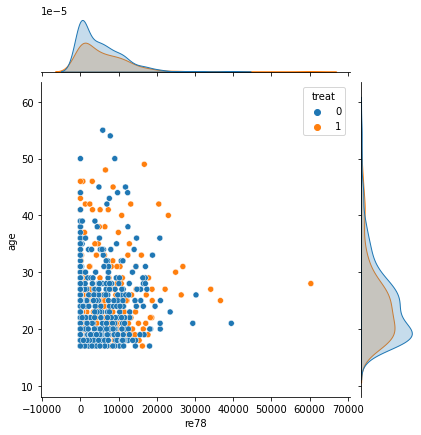

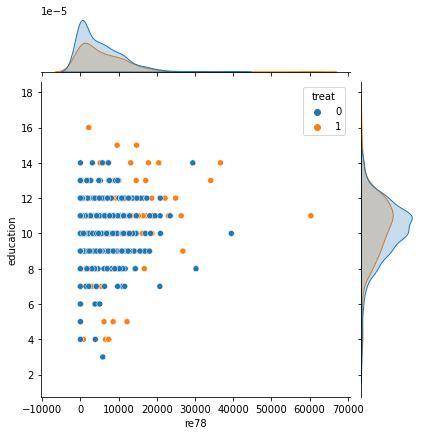

In [114]:
sns.jointplot(data = nsw, x = nsw['re78'], y  = nsw['age'], hue = nsw['treat'])
sns.jointplot(data = nsw, x = nsw['re78'], y  = nsw['education'], hue = nsw['treat'])

In [4]:
# Sample means and standard deviations 
nsw_teatment_subsample = nsw[nsw['treat']==1]
nsw_control_subsample = nsw[nsw['treat']==0]

treatment_subsample_mean_sd = nsw_teatment_subsample.describe().loc[['mean','std']].T
control_subsample_mean_sd = nsw_control_subsample.describe().loc[['mean','std']].T

treat_control_comparison = pd.concat([treatment_subsample_mean_sd, control_subsample_mean_sd], axis=1)

superlables = {'treated':['mean','sd'],'control':['mean','sd']}

treat_control_comparison.columns = pd.MultiIndex.from_frame(pd.DataFrame(superlables).melt())

print(treat_control_comparison)

variable     treated              control          
value           mean        sd       mean        sd
treat       1.000000  0.000000   0.000000  0.000000
age        24.626263  6.686391  24.447059  6.590276
education  10.380471  1.817712  10.188235  1.618686
black       0.801347  0.399660   0.800000  0.400471
hispanic    0.094276  0.292706   0.112941  0.316894
married     0.168350  0.374808   0.157647  0.364839
nodegree    0.730640  0.444376   0.814118  0.389470
re75        4.980574  3.956109   4.641999  4.038931
re78        6.600638  3.689926   5.931764  4.018885


In [24]:
#Further sumbsample
nsw_degree = nsw[nsw['nodegree']==1]
nsw_nodegree = nsw[nsw['nodegree']==0]

# has degree subsample
nsw_teatment_degree_subsample = nsw_degree[nsw_degree['treat']==1]
nsw_control_degree_subsample = nsw_degree[nsw_degree['treat']==0]

# no degree subsample
nsw_teatment_nodegree_subsample = nsw_nodegree[nsw_nodegree['treat']==1]
nsw_control_nodegree_subsample = nsw_nodegree[nsw_nodegree['treat']==0]

# degree mean sd
nsw_teatment_degree_subsample = nsw_teatment_degree_subsample.describe().loc[['mean','std']].T
nsw_control_degree_subsample = nsw_control_degree_subsample.describe().loc[['mean','std']].T
# no degree mean sd
nsw_teatment_nodegree_subsample = nsw_control_nodegree_subsample.describe().loc[['mean','std']].T
nsw_control_nodegree_subsample = nsw_control_nodegree_subsample.describe().loc[['mean','std']].T

# tabulate 
treat_control_degree_comparison = pd.concat([nsw_teatment_degree_subsample, nsw_control_degree_subsample], axis=1)
treat_control_no_degree_comparison = pd.concat([nsw_teatment_nodegree_subsample, nsw_control_nodegree_subsample], axis=1)

superlables = {'treated degree':['mean','sd'],'control degree':['mean','sd']}
superlables2 = {'treated no degree':['mean','sd'],'control no degree':['mean','sd']}

treat_control_degree_comparison.columns = pd.MultiIndex.from_frame(pd.DataFrame(superlables).melt())
treat_control_no_degree_comparison.columns = pd.MultiIndex.from_frame(pd.DataFrame(superlables2).melt())

# comabine all tables
four_groups = pd.concat([treat_control_degree_comparison, treat_control_no_degree_comparison], axis=1)

four_groups

variable  treated degree           control degree           treated no degree  \
value               mean        sd           mean        sd              mean   
treat           1.000000  0.000000       0.000000  0.000000          0.000000   
age            24.276498  6.892498      23.982659  6.802364         26.481013   
education       9.640553  1.496853       9.705202  1.370423         12.303797   
black           0.811060  0.392366       0.806358  0.395724          0.772152   
hispanic        0.110599  0.314360       0.124277  0.330376          0.063291   
married         0.170507  0.376947       0.153179  0.360682          0.177215   
nodegree        1.000000  0.000000       1.000000  0.000000          0.000000   
re75            5.011521  3.933472       4.433035  4.036108          5.557216   
re78            6.531750  3.695176       5.839246  4.036904          6.336962   

variable            control no degree            
value            sd              mean        sd  
treat      0.000000          0.000000  0.000000  
age        5.126254         26.481013  5.126254  
education  0.606681         12.303797  0.606681  
black      0.422124          0.772152  0.422124  
hispanic   0.245042          0.063291  0.245042  
married    0.384291          0.177215  0.384291  
nodegree   0.000000          0.000000  0.000000  
re75       3.947268          5.557216  3.947268  
re78       3.938528          6.336962  3.938528

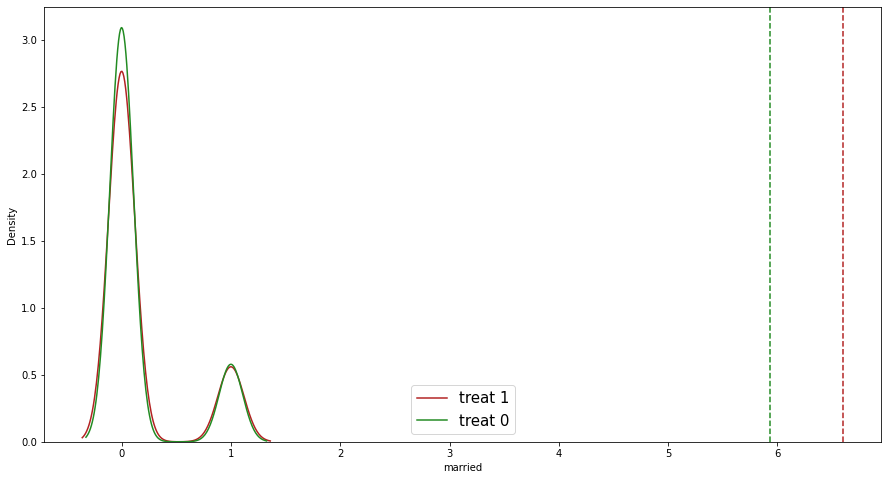

In [30]:
from statistics import mode
plt.figure(figsize=(15,8))
# Density plots for treatment and control
sns.kdeplot(data=nsw['married'][nsw['treat']==1],color = 'firebrick',label="treat 1")
sns.kdeplot(data=nsw['married'][nsw['treat']==0],color = 'forestgreen',label="treat 0")
plt.legend(fontsize=15)
# mean and mode - treated 
#plt.axvline(mode(nsw['re78'][nsw['treat']==1]), color='firebrick', linestyle='-')
plt.axvline(nsw['re78'][nsw['treat']==1].mean(), color='firebrick', linestyle='--')
# mean and mode - control 
#plt.axvline(mode(nsw['re78'][nsw['treat']==0]), color='lime', linestyle='-')
plt.axvline(nsw['re78'][nsw['treat']==0].mean(), color='forestgreen', linestyle='--')

<p> Taking logs of wage reveals that the distribution is bimodal </p>
<p> There are a group of low wage earners (o mode) and higher wave earns (c8 mode) </p>
<p> Treatment decreases amount of low wage earns, increases amount of high wave earners</p>

### Plot histograms comparing outcome from those with and without degrees

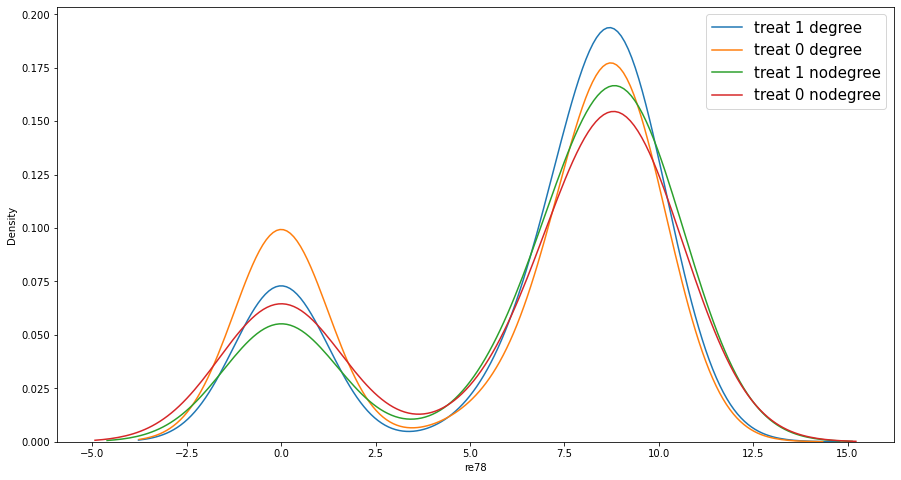

In [48]:
plt.figure(figsize=(15,8))
# Density plots for treatment and control
sns.kdeplot(data=nsw['re78'][(nsw['treat']==1) & (nsw['nodegree']==1)],label="treat 1 degree")
sns.kdeplot(data=nsw['re78'][(nsw['treat']==0) & (nsw['nodegree']==1)],label="treat 0 degree")
sns.kdeplot(data=nsw['re78'][(nsw['treat']==1) & (nsw['nodegree']==0)],label="treat 1 nodegree")
sns.kdeplot(data=nsw['re78'][(nsw['treat']==0) & (nsw['nodegree']==0)],label="treat 0 nodegree")
plt.legend(fontsize=15)
# mean and mode - treated 
#plt.axvline(mode(nsw['re78'][nsw['treat']==1]), color='firebrick', linestyle='-')
#plt.axvline(nsw['re78'][nsw['treat']==1].mean(), color='firebrick', linestyle='--')
# mean and mode - control 
#plt.axvline(mode(nsw['re78'][nsw['treat']==0]), color='lime', linestyle='-')
#plt.axvline(nsw['re78'][nsw['treat']==0].mean(), color='forestgreen', linestyle='--')

In [42]:
print(nsw['re78'][nsw['re78']==1 ])
nsw['re78'][(nsw['re78']==1) & (nsw['nodegree']==0)]

Series([], Name: re78, dtype: float32)


Series([], Name: re78, dtype: float32)

## PC Algorithm

In [9]:
# Get skeleton graph
treat_0 = nsw[nsw['treat']==0]
treat_1 = nsw[nsw['treat']==1]
del treat_0['treat']
del treat_1['treat']
glasso = cdt.independence.graph.Glasso()
skeleton = glasso.predict(nsw)
skeleton_treat0 = glasso.predict(treat_0)
skeleton_treat1 = glasso.predict(treat_1)

In [10]:
import cdt
import networkx as nx
cdt.SETTINGS.rpath = '/Library/Frameworks/R.framework/Versions/4.0/Resources/Rscript'

PC is ran on the skeleton of the given graph.


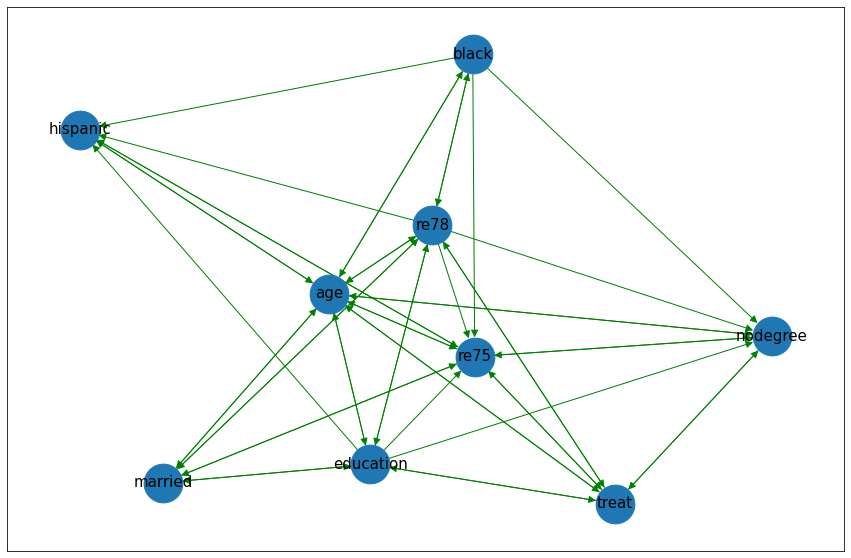

In [11]:
#Run PC algorithm
model_pc = cdt.causality.graph.PC()
graph_pc_treat0 = model_pc.predict(treat_0, skeleton_treat0)
fig=plt.figure(figsize=(15,10))
nx.draw_networkx(graph_pc_treat0, font_size=15 ,node_size=1500,edge_cmap='Reds',arrowsize=15,edge_color='Green')

PC is ran on the skeleton of the given graph.


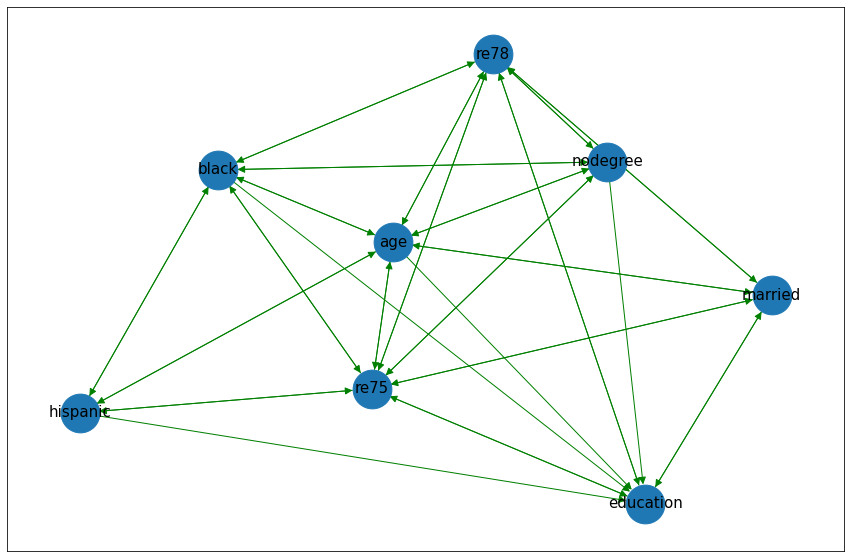

In [7]:
model_pc = cdt.causality.graph.PC()
graph_pc_treat1 = model_pc.predict(treat_1, skeleton_treat1)
fig=plt.figure(figsize=(15,10))
nx.draw_networkx(graph_pc_treat1, font_size=15 ,node_size=1500,edge_cmap='Reds',arrowsize=15,edge_color='Green')


PC is ran on the skeleton of the given graph.


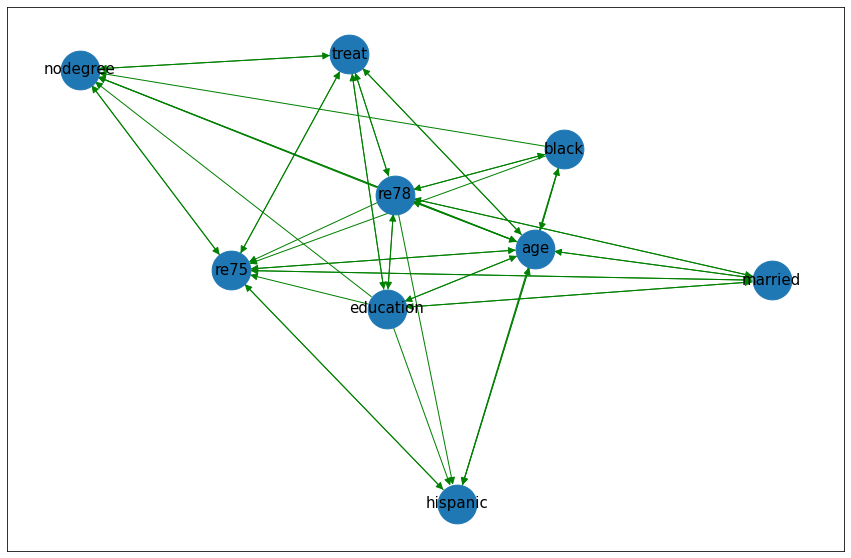

In [13]:
glasso = cdt.independence.graph.Glasso()
skeleton = glasso.predict(nsw)
model_pc = cdt.causality.graph.PC()
graph_pc_nsw = model_pc.predict(nsw, skeleton)
fig =plt.figure(figsize=(15,10))
nx.draw_networkx(graph_pc_nsw, font_size=15 ,node_size=1500,edge_cmap='Reds',arrowsize=15,edge_color='Green')

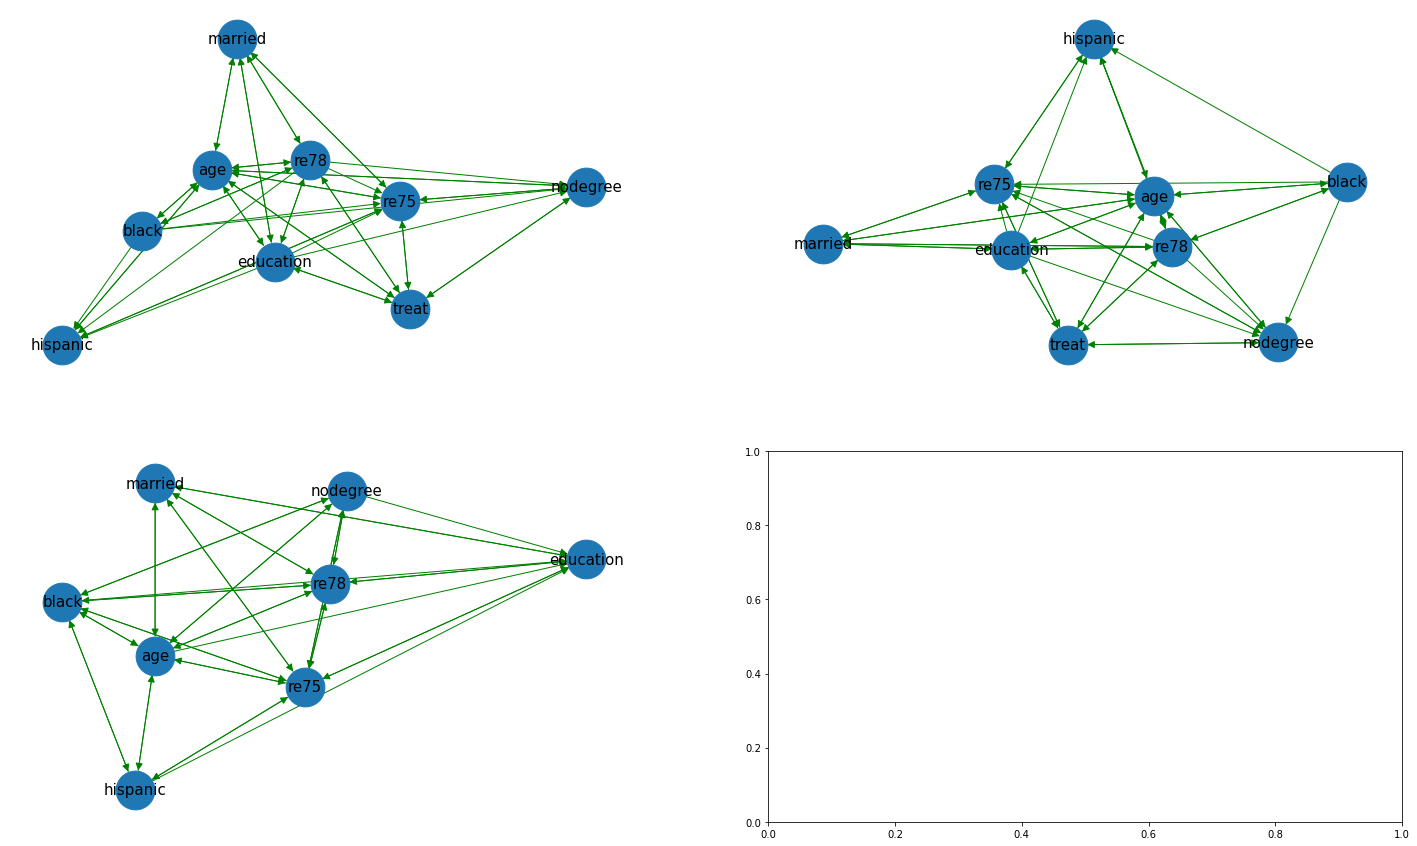

In [14]:
#Plot all graphs

graphs = [graph_pc_nsw,graph_pc_treat0,graph_pc_treat1]
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(25, 15))
#fig, axs = plt.subplot_mosaic([['a)'], ['b)'], ['d)']])

ax = axes.flatten()

for i in range(3):
    nx.draw_networkx(graphs[i],font_size=15 ,node_size=1500,edge_cmap='Reds',arrowsize=15,edge_color='Green' , ax=ax[i])
    ax[i].set_axis_off()

plt.show()


## My own implementation of the PC algorithm

<p> generate complete, undirected graph </p>

In [1]:
import torch 
import networkx as nx

In [5]:
from torch_geometric.utils.convert import from_networkx

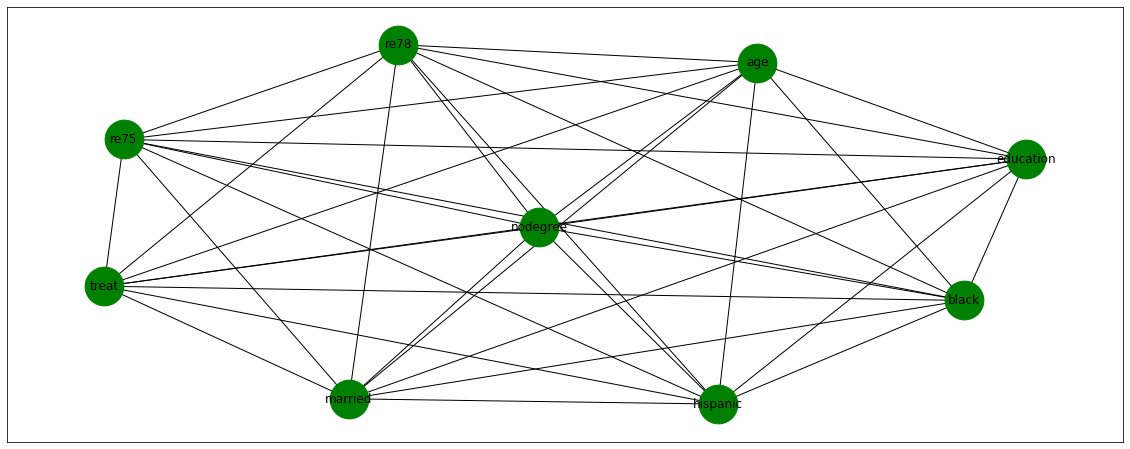

In [12]:
C = nx.complete_graph(nsw)
C_matrix = nx.to_numpy_matrix(C)
C_df = pd.DataFrame(np.matrix(C_matrix))

#Plot graph 
fig=plt.figure(figsize=(20,8))
nx.draw_networkx(C, node_color = 'green',node_size = 1500)

<p> test's for conditional independence </p>

In [1]:
pyg_graph = from_networkx(C)

NameError: name 'from_networkx' is not defined

In [5]:
# Conditonal independence testing using the CCIT - https://arxiv.org/abs/1709.06138
from CCIT import CCIT
from CCIT import DataGen

nsw = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Data/nsw.dta")
del nsw['data_id']
#Normalise data between a range of 0 and 1
for col in nsw.columns:
    nsw[col] = (nsw[col] - np.min(nsw[col])) / (np.max(nsw[col]) - np.min(nsw[col])) 

# Convert variables to numpy arrays  

treat_a  = np.array([nsw['treat']])
age_a  = np.array([nsw['age']])
educ_a  = np.array([nsw['education']])
black_a = np.array(nsw['black'])
hispanic_a = np.array(nsw['hispanic'])
married_a = np.array(nsw['married'])
nodegree_a = np.array(nsw['nodegree'])
re75_a = np.array(nsw['re75'])
re78_a = np.array(nsw['re78'])

# Reshape arrays 

treat_a = treat_a.reshape(722,1)
age_a = age_a.reshape(722,1)
educ_a = educ_a.reshape(722,1)
black_a = black_a.reshape(722,1)
hispanic_a = hispanic_a.reshape(722,1)
married_a = married_a.reshape(722,1)
nodegree_a = nodegree_a.reshape(722,1)
re75_a = re75_a.reshape(722,1)
re78_a = re78_a.reshape(722,1)


## Generate sets for conditional independence testing 

emptyset = [0]*722
emptyset = np.array(emptyset)
emptyset = emptyset.reshape(722,1)

# n-dimensional arrays

z_1 = np.array(nsw[['married','hispanic','education']])


<p> Run CI test </p>

In [208]:
#0th order CI test
ci_pvals = []
pvalue = CCIT.CCIT(age_a,nodegree_a,z_1) 
ci_pvals.append(pvalue)
ci_pvals

[0.5222283244921728]

In [163]:
# Produce undirected graph F from conditional independence test and iterate 

0.5664097963506411

In [164]:
C_matrix = nx.to_numpy_matrix(C)

In [177]:
# Visualise the complete graph as a dataframe
cols = {0:'treat',1:'age',2:'education',3:'black',4:'hispanic',5:'married',6:'nodegree',7:'re75',8:'re78'}
rows = {0:'treat',1:'age',2:'education',3:'black',4:'hispanic',5:'married',6:'nodegree',7:'re75',8:'re78'}
C_df = C_df.rename(columns=cols, index=rows)
C_df

,treat,age,education,black,hispanic,married,nodegree,re75,re78
treat,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
age,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
education,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
black,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
hispanic,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
married,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
nodegree,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
re75,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
re78,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


,treat,age,education,black,hispanic,married,nodegree,re75,re78
treat,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
age,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
education,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
black,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
hispanic,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
married,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
nodegree,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
re75,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
re78,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [181]:
def combs(a):
    if len(a) == 0:
        return [[]]
    cs = []
    for c in combs(a[1:]):
        cs += [c, c+[a[0]]]
    return cs

combinations = combs([0,1,2,3,4,5,6,7,8,9])